# Hypothesis Testing with Men's and Women's Soccer Matches using PYTHON

#### Import libraries

In [109]:
import pandas as pd
import pingouin
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Read the files

In [110]:
men_df = pd.read_csv(r"C:\Users\Jamaica\Desktop\Kian's File\Personal file\Projects\Hypothesis Testing with Men's and Women's Soccer Matches\men_results.csv")
women_df = pd.read_csv(r"C:\Users\Jamaica\Desktop\Kian's File\Personal file\Projects\Hypothesis Testing with Men's and Women's Soccer Matches\women_results.csv")

#### Inspect structure and check data range

In [ ]:
men_df.columns

In [ ]:
print("Men's data:")
print(men_df.info())
print("\nWomen's data:")
print(women_df.info())

print("\nMen's date range:", men_df['date'].min(), "to", men_df['date'].max())
print("Women's date range:", women_df['date'].min(), "to", women_df['date'].max())      

#### Convert Dates to datetime format

In [113]:
men_df['date'] = pd.to_datetime(men_df['date'])
women_df['date'] = pd.to_datetime(women_df['date'])

#### Filter for FIFA World Cup matches since 2002-01-01

In [114]:
men_wc = men_df[(men_df['tournament'] == 'FIFA World Cup') & (men_df['date'] >= '2002-01-01')]
women_wc = women_df[(women_df['tournament'] == 'FIFA World Cup') & (women_df['date'] >= '2002-01-01')]

#### Analyzing Number of Matches

In [ ]:
# Match counts
match_counts = {
    "Men's World Cup": len(men_wc),
    "Women's World Cup": len(women_wc)
}

# Convert to DataFrame for seaborn
counts_df = pd.DataFrame(list(match_counts.items()), columns=["Tournament", "Matches"])


plt.figure(figsize=(6, 5))
ax = sns.barplot(x="Tournament", y="Matches", data=counts_df, palette=["blue", "red"], hue="Tournament", legend=False)
# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)

plt.title("Number of Matches Analyzed (Since 2002)", fontsize=14)
plt.ylabel("Number of Matches")
plt.xlabel("")
plt.tight_layout()
plt.show()


#### Calculate total goals per match

In [ ]:
men_wc['total_goals'] = men_wc['home_score'] + men_wc['away_score']
women_wc['total_goals'] = women_wc['home_score'] + women_wc['away_score']
print(men_wc)
print(women_wc)

#### Print basic statistics

In [ ]:
print("\nMen's World Cup matches (since 2002):")
print(f"Number of matches: {len(men_wc)}")
print(f"Goal stats: Mean={men_wc['total_goals'].mean():.2f}, Median={men_wc['total_goals'].median()}, Std={men_wc['total_goals'].std():.2f}")

print("\nWomen's World Cup matches (since 2002):")
print(f"Number of matches: {len(women_wc)}")
print(f"Goal stats: Mean={women_wc['total_goals'].mean():.2f}, Median={women_wc['total_goals'].median()}, Std={women_wc['total_goals'].std():.2f}")

Total goals: Men vs Women

In [ ]:
# Make copies to avoid SettingWithCopyWarning
men_wc = men_wc.copy()
women_wc = women_wc.copy()

# Add gender column
men_wc["gender"] = "Men"
women_wc["gender"] = "Women"

# Combine into single dataframe
combined = pd.concat([men_wc[['total_goals','gender']], 
                      women_wc[['total_goals','gender']]])

# ---- Seaborn Visualizations ----

plt.figure(figsize=(12,6))

# 1. Boxplot comparison
plt.subplot(1,2,1)
sns.boxplot(
    data=combined,
    x="gender", 
    y="total_goals", 
    hue="gender",
    dodge=False, 
    palette={"Men":"blue","Women":"red"},
    legend=False
)
plt.title("Boxplot of Total Goals per Match")

plt.subplot(1,2,2)
ax = sns.barplot(
    data=combined,
    x="gender", 
    y="total_goals", 
    estimator=np.mean, 
    errorbar="sd",       # replaces ci="sd"
    hue="gender",        
    palette={"Men": "blue", "Women": "red"},
    dodge=False          
)

# Add values on top of bars
for p in ax.patches:
    value = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        value + 0.05,                   # y position (slightly above bar)
        f"{value:.2f}",                 # formatted value
        ha="center", va="bottom", fontsize=10, color="black"
    )

plt.title("Average Total Goals per Match (Men vs Women)")
plt.ylabel("Average Goals")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()


#### Check distributions visually

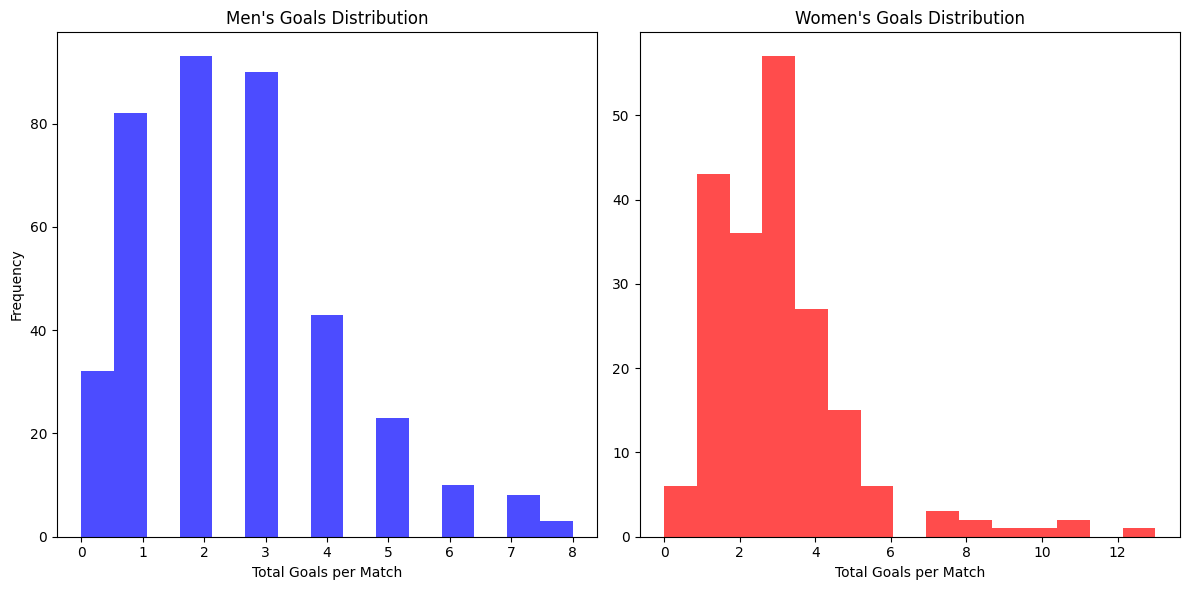

In [119]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(men_wc['total_goals'], bins=15, color='blue', alpha=0.7)
plt.title("Men's Goals Distribution")
plt.xlabel('Total Goals per Match')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(women_wc['total_goals'], bins=15, color='red', alpha=0.7)
plt.title("Women's Goals Distribution")
plt.xlabel('Total Goals per Match')
plt.tight_layout()
plt.show()

#### Check normality statistically

In [ ]:
men_normal = stats.shapiro(men_wc['total_goals']).pvalue > 0.05
women_normal = stats.shapiro(women_wc['total_goals']).pvalue > 0.05

print(f"\nNormality test results:")
print(f"Men's goals normal? {'Yes' if men_normal else 'No'}")
print(f"Women's goals normal? {'Yes' if women_normal else 'No'}")

#### Based on this, we'll choose the appropriate test

In [ ]:
if men_normal and women_normal:
    print("\nBoth distributions normal - using t-test")
else:
    print("\nNon-normal distributions - using Mann-Whitney U test")

#### Since goals are discrete and distributions are likely skewed, we'll use Mann-Whitney U

In [ ]:
result = pingouin.mwu(
    women_wc['total_goals'], 
    men_wc['total_goals'],
    alternative='greater'  # We suspect women's matches have MORE goals
)

print(f"\nMann-Whitney U Test Results:")
print(f"U statistic: {result['U-val'].values[0]}")
print(f"P-value: {result['p-val'].values[0]:.6f}")

#### Conclusion

In [ ]:
alpha = 0.10  # 10% significance level

if p_val <= alpha:
    result = "reject"
    print("\nConclusion: Reject H0 - Women's matches have significantly more goals")
else:
    result = "fail to reject"
    print("\nConclusion: Fail to reject H0 - No significant difference in goals")

# Create result dictionary
result_dict = {"p_val": p_val, "result": result}
#print(result_dict)

In [ ]:
plt.figure(figsize=(12, 6))

# --- First chart: p-value vs alpha ---
plt.subplot(1, 2, 1)
ax = sns.barplot(
    x=["p-value", "alpha"], 
    y=[p_val, alpha], 
    palette=["red", "blue"], 
    hue=["p-value", "alpha"], 
    legend=False
)

# Annotate values on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",   # format to 3 decimals
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight="bold")

# Add horizontal alpha line
plt.axhline(y=alpha, color="blue", linestyle="--", label=f"alpha = {alpha}")
plt.title("Hypothesis Test: p-value vs α")
plt.ylabel("Value")
plt.legend()

# --- Second chart: Goals distribution ---
plt.subplot(1, 2, 2)
sns.histplot(men_wc['total_goals'], color="blue", label="Men", kde=True)
sns.histplot(women_wc['total_goals'], color="red", label="Women", kde=True)
plt.title("Goals Distribution with Hypothesis Test Result")
plt.xlabel("Total Goals per Match")
plt.legend()

# Annotate hypothesis test result
plt.text(7, 15, f"Hypothesis Test: {result}", fontsize=12, color="green")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(men_wc['total_goals'], color="blue", label="Men", kde=True)
sns.histplot(women_wc['total_goals'], color="red", label="Women", kde=True)
plt.title("Goals Distribution with Hypothesis Test Result")
plt.xlabel("Total Goals per Match")
plt.legend()

# Annotate result
plt.text(7, 15, f"Hypothesis Test: {result}", fontsize=12, color="green")
plt.show()